<center><img src="https://images.squarespace-cdn.com/content/v1/5d5ebe0290b74100011fd096/1596042157547-KXGXKTJQ4KH2DDXM5726/FourthBrain%28noDescritor%29Logo.png?format=1500w" width=200 height=200 /></center>

# 3D-Packing Datasets

## Pre-requisites

In [5]:
import sys
sys.path.append("/mnt/c/Users/crist/Documents/3D-Packing/nb/") # replace with your path

In [6]:
pwd

'/mnt/c/Users/crist/Documents/3D-Packing/nb'

## Check libraries

In [7]:
%pip install loguru
%pip install ortools
%pip install rectpack
%pip install nb_black

/bin/bash: /home/cim/anaconda3/envs/packing_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/cim/anaconda3/envs/packing_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/cim/anaconda3/envs/packing_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/cim/anaconda3/envs/packing_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [9]:
%cd ../src

/mnt/c/Users/crist/Documents/3D-Packing/src


In [10]:
import config_2D, config_3D, dataset_2D, dataset_3D, utils_2D, utils_3D

In [11]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [12]:
plt.style.use("seaborn")
np.random.seed(config_2D.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Containers

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |


## 2D Dataset

### Products

In [13]:
product_dataset2d = dataset_2D.ProductDataset2D(
    "../data/products_2D.pkl", # save dataset to directory
    config_2D.NUM_PRODUCTS, # 1e6
    config_2D.MIN_PRODUCT_WIDTH,
    config_2D.MAX_PRODUCT_WIDTH,
    config_2D.MIN_PRODUCT_HEIGHT,
    config_2D.MAX_PRODUCT_HEIGHT,
    force_overload=True, # Generate new dataset
)
print("Dimensions are in cm and liter:")
product_dataset2d.products.head()


Dimensions are in cm and liter:


,width,height,volume
0,20,21,4.2
1,27,30,8.1
2,20,20,4.0
3,120,66,79.2
4,120,49,58.8


<IPython.core.display.Javascript object>

check the result from export file

In [14]:
dataset_data_2d = pd.read_pickle("../data/products_2D.pkl")
dataset_data_2d.head()

,width,height,volume
0,20,21,4.2
1,27,30,8.1
2,20,20,4.0
3,120,66,79.2
4,120,49,58.8


<IPython.core.display.Javascript object>

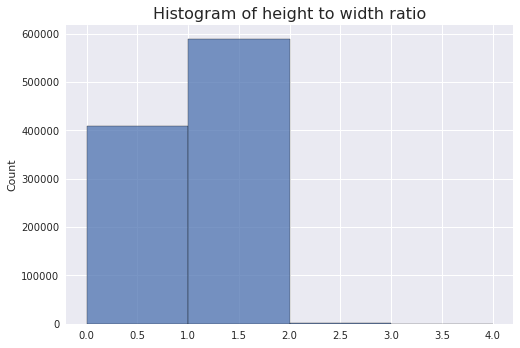

<IPython.core.display.Javascript object>

In [15]:
plt.figure()
sns.histplot(
    product_dataset2d.products.height / product_dataset2d.products.width,
    bins=np.arange(0, 5, 1),
)
plt.title("Histogram of height to width ratio", fontsize=16)
plt.show()


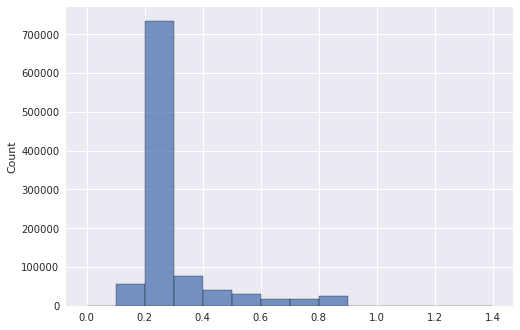

<IPython.core.display.Javascript object>

In [16]:
plt.figure()
sns.histplot(
    product_dataset2d.products.volume / product_dataset2d.products.width,
    bins=np.arange(0, 1.5, 0.1),
)
plt.show()

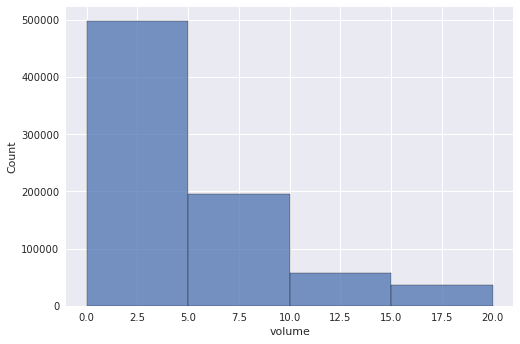

<IPython.core.display.Javascript object>

In [17]:
plt.figure()
sns.histplot(product_dataset2d.products.volume, bins=np.arange(0, 25, 5))
plt.show()

/home/cim/anaconda3/envs/packing_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


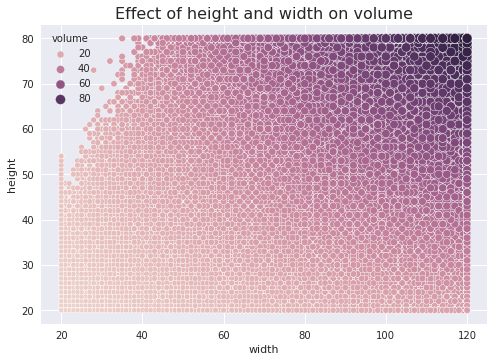

<IPython.core.display.Javascript object>

In [19]:
plt.figure()
sns.scatterplot(
    data=product_dataset2d.products,
    x="width",
    y="height",
    size="volume",
    hue="volume"
)
plt.title("Effect of height and width on volume", fontsize=16)
plt.show()


### Order

In [20]:
ordered_products = 100
order = product_dataset2d.get_order(ordered_products)
# order = pd.read_csv("data/test_order.csv")
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,height,volume
0,847666,20,24,4.8
1,806505,20,20,4.0
2,26424,43,20,8.6
3,200498,24,20,4.8
4,91480,20,20,4.0


<IPython.core.display.Javascript object>

## 3D Dataset

In [21]:
product_dataset_3d = dataset_3D.ProductDataset3D(
    "../data/products_3D.pkl",
    config_3D.NUM_PRODUCTS,
    config_3D.MIN_PRODUCT_WIDTH,
    config_3D.MAX_PRODUCT_WIDTH,
    config_3D.MIN_PRODUCT_DEPTH,
    config_3D.MAX_PRODUCT_DEPTH,
    config_3D.MIN_PRODUCT_HEIGHT,
    config_3D.MAX_PRODUCT_HEIGHT,
    force_overload=True, # Generate new dataset
)
product_dataset_3d.products.head()

/mnt/c/Users/crist/Documents/3D-Packing/src/dataset_3D.py:60: RuntimeWarning: invalid value encountered in power
  np.power((volumes / (dw_ratios * hw_ratios)), 1/3),


,width,depth,height,volume
0,50,50,136,340.0
1,50,50,93,232.5
2,50,50,120,300.0
3,50,50,82,205.0
4,50,50,125,312.5


<IPython.core.display.Javascript object>

In [22]:
dataset_data_3d = pd.read_pickle("../data/products_3D.pkl")
dataset_data_3d.head()

,width,depth,height,volume
0,50,50,136,340.0
1,50,50,93,232.5
2,50,50,120,300.0
3,50,50,82,205.0
4,50,50,125,312.5


<IPython.core.display.Javascript object>